# BM25

In [1]:
import os
import sys
import math
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def word_cloud(text: list):
  """text: list of text documents/sentences"""
  text = [str(i) for i in text]
  text = ' '.join(text).lower()
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()


# embedding

In [3]:
class BM25Vectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, k1=1.5, b=0.75, stop_words=None):
        self.k1 = k1
        self.b = b
        self.stop_words = stop_words
        self.tfidf = TfidfVectorizer(stop_words=stop_words, smooth_idf=False, sublinear_tf=False)
    
    def fit(self, X, y=None):
        self.tfidf.fit(X)
        self.avgdl = np.mean([len(doc.split()) for doc in X])
        return self
    
    def transform(self, X):
        tf = self.tfidf.transform(X)
        tf = tf.toarray()
        len_X = np.array([len(doc.split()) for doc in X])[:, None]
        idf = self.tfidf.idf_[None, :]
        numerator = tf * (self.k1 + 1)
        denominator = tf + self.k1 * (1 - self.b + self.b * len_X / self.avgdl)
        return (idf * numerator / denominator)

In [4]:
class BM25():
  """
  data: list of strings
  token_len: avg | min | max | avg_max[avg of avg and max]
  freq_sat - frequency_saturation : float
  len-norm - length of normalisation : float
  token_len - tokens length per document ot have same length in all docs
  """
  def __init__(self, data: list, freq_sat=1, len_norm=1.5, tokens_len='avg'):
    self.data = list(data)
    self.freq_sat = freq_sat
    self.len_norm = len_norm
    self.tokens_len = tokens_len.lower()
    # used for filling short documents to make documents have equal lengths
    self.special_token: float = np.finfo(np.float32).eps # sys.float_info.epsilon # use the
    self.normalise_data()
  
  def normalise_data(self): self.data = [ str(doc).lower() for doc in self.data ]

  def TF(self, t, d):
    f = self.freq_term_document(t, d)
    n = f * self.freq_saturation()
    dd = f + (self.freq_sat * ( 1 - self.len_norm + self.len_norm * ( self.len_doc(d) / self.avg_doc_length() )))
    return n / dd
  
  def freq_saturation(self,): return self.freq_sat + 1
  
  def len_doc(self, d): return len( d.split(" ") )
  
  def avg_doc_length(self,): 
    return sum( [ len(d.split(" ")) for d in self.data ] ) / self.__len__()
  
  def freq_term_document(self, t, d): return d.split(" ").count(t)
  
  def IDF(self, t):
    n = self.__len__() - self.numb_doc_with_term(t) + .5
    d = self.numb_doc_with_term(t) + .5
    y = np.log((n/d)+1)
    return y

  def transform(self):
    """ variant, modified to fit my use case """
    res = []
    for doc in self.data: 
      x = [ self.TF(t, doc) * self.IDF(t) for t in doc.split(" ") ]
      res.append(x)
    res = self._token_length(res)
    return res

  def numb_doc_with_term(self, t):
    c = 0;
    for doc in self.data: 
      if t in doc: c += 1
    return c
  
  def len_document(self, d): 
    return len(d.split(" "))
  
  def __len__(self): return len(self.data)
  
  def _token_len_min(self):
    return min([len(i.split(' ')) for i in self.data])
  
  def _token_len_max(self):
    return max([len(i.split(' ')) for i in self.data])
  
  def _token_len_avg(self):
    return round(sum( [len(d.split(' ')) for d in self.data] ) / len(self.data))
  
  def _vocabulary(self):
    '''
    - store unique words from the entire document
    - store vocab using their bm25, so that its can be easily to map back from bm25 number to word used
    '''
    pass
  
  def get_feature_names(self):
    """returns unique terms/words from training corpus"""
    x = ' '.join(self.data)
    x = ' '.join(x.split()).lower().split(' ')
    return x
  
  def _vocabulary_length(self):
    '''get the length of unique words from the data corpus'''
    x = self.get_feature_names()
    return len(set(x))
    
  def _token_length(self, embs ):
    tl = []
    tlen = 0
    # 
    if self.tokens_len == 'min': tlen = self._token_len_min()
    elif self.tokens_len == 'max': tlen = self._token_len_max()
    elif self.tokens_len == 'avg_max': tlen = math.ceil( (self._token_len_max() + self._token_len_avg() ) / 2 )
    else : tlen = self._token_len_avg()
    # 
    for d in embs:
      if len(d) < tlen: d.extend( [ self.special_token for _ in range(len(d), tlen)])
      else: d = d[: tlen]
      tl.append(d)
      
    return tl

# data

In [5]:
train = pd.read_csv("./data/train.csv")
train.head()

,label,text,targets
0,positive,im getting on borderlands and i will murder yo...,1
1,positive,i am coming to the borders and i will kill you...,1
2,positive,im getting on borderlands and i will kill you all,1
3,positive,im coming on borderlands and i will murder you...,1
4,positive,im getting on borderlands 2 and i will murder ...,1


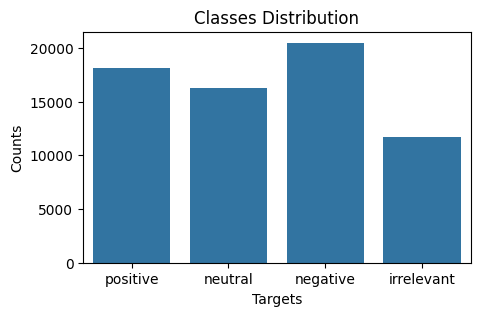

In [6]:
plt.figure(figsize=(5, 3))
sns.countplot(data=train, x ='label')
plt.ylabel("Counts")
plt.xlabel("Targets")
plt.title("Classes Distribution")
plt.show()

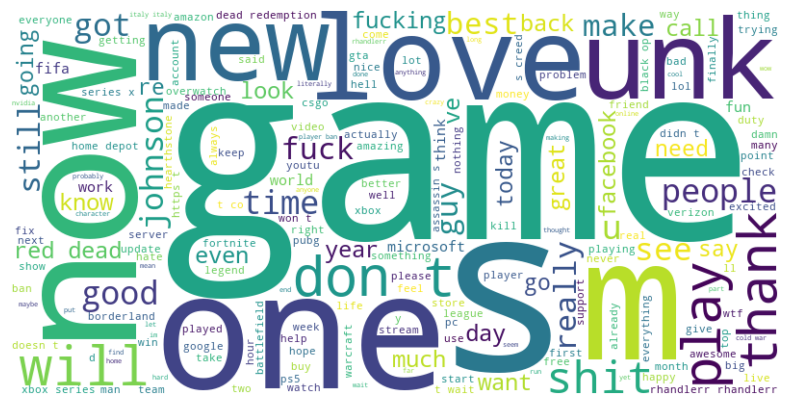

In [7]:
x = list( train['text'].values )
word_cloud(x)

# tf-idf

In [8]:
data_text = train['text'].values
len(data_text)

66569

In [9]:
vectorizer = TfidfVectorizer()
vectorizer.fit(data_text)
tfidf_matrix = vectorizer.transform(data_text)
# feature_names = vectorizer.get_feature_names_out()
tfidf_matrix = tfidf_matrix.toarray()

tfidf_matrix.shape

(66569, 30168)

In [10]:
labels = train['targets']
labels.shape, tfidf_matrix.shape

((66569,), (66569, 30168))

In [11]:
nb_tfidf = MultinomialNB()

nb_tfidf.fit(tfidf_matrix, labels)

MultinomialNB()

# bm25

In [12]:
mx = max( [ len(i) for i in data_text ] )
mi = min( [ len(i) for i in data_text ] )
avg = sum( [ len(i) for i in data_text ] ) / len(data_text)
mx, mi, avg

(919, 3, 104.59264822965645)

### both implementation of bm25, crash kernel - not enough power

In [13]:
# # bm25 = BM25(data_text,tokens_len='avg')
# vectorizer_bm25 = BM25Vectorizer()
# vectorizer_bm25.fit(data_text)
# bm25_vectors = vectorizer_bm25.transform(data_text)
# bm25_vectors.shape

# val

In [14]:
val = pd.read_csv("./data/val.csv")
val.head()

,label,text,targets
0,irrelevant,i mentioned on facebook that i was struggling ...,4
1,neutral,bbc news - amazon boss jeff bezos rejects clai...,2
2,negative,why do i pay for word when it functions so poo...,3
3,negative,csgo matchmaking is so full of closet hacking ...,3
4,neutral,now the president is slapping americans in the...,2


In [15]:
val_x = val['text'].values
val_y = val['targets'].values
val_x.shape, val_y.shape

((985,), (985,))

### tf-idf

In [16]:
test_X = vectorizer.transform(val_x)
test_X = test_X.toarray()
test_X.shape

(985, 30168)

In [17]:
y_pred = nb_tfidf.predict(test_X)
y_pred.shape

(985,)

In [18]:
print(classification_report( val_y, y_pred, zero_division=1 ) )

              precision    recall  f1-score   support

           1       0.74      0.88      0.80       273
           2       0.90      0.64      0.75       280
           3       0.68      0.93      0.79       261
           4       0.95      0.56      0.70       171

    accuracy                           0.77       985
   macro avg       0.82      0.75      0.76       985
weighted avg       0.81      0.77      0.77       985



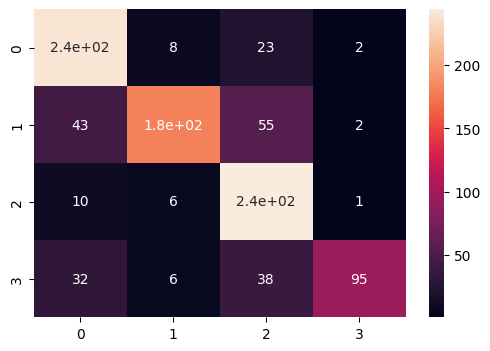

In [19]:
conf_mat = confusion_matrix(val_y, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap( conf_mat, annot=True )
plt.show()

### bm25

# summary

- my bm25 vectorizer is slow 